# 1. Title, Name and References

#### Title

#### Introduction

#### Team member
1. Ngoc Chau Tran - 300307368
2. Leozítor Floro de Souza - 300334919
3. Carolina Henrique de Melo Louback - 300306289

#### References

# 2. Library import and data loading

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns

import statsmodels.api as sm
%matplotlib inline

# 3. Data Analysis, Preparation and Wrangling

In [11]:
df = pd.read_csv('bank-sampled-9K.csv')
df2 = pd.read_csv('bank-sampled.csv')

In [12]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown,no
1,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown,no
2,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown,no
3,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure,no
4,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9037,26,admin.,single,tertiary,no,689,no,no,cellular,25,mar,78,1,-1,0,unknown,no
9038,47,management,married,tertiary,no,1890,no,no,cellular,8,jul,161,1,-1,0,unknown,no
9039,32,blue-collar,single,secondary,no,217,yes,no,cellular,15,may,692,3,-1,0,unknown,yes
9040,52,admin.,divorced,secondary,no,0,yes,no,unknown,26,may,206,1,-1,0,unknown,no


In [13]:
df2

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [14]:
# dropping duration as suggested by the documentation
df2.drop('duration', axis=1, inplace=True)

#Convert the two-column time to a column containing the number of days till the last day of campaing
last_date = "18 Nov, 2010" # assume the analysis date was nov 18th 2010.
dt_1 = dt.strptime(last_date, "%d %b, %Y") #change it to datetime

#Convert month first letter to upper case
df2['month'] = df2['month'].apply(lambda x: x.capitalize())
df2['date'] = df2['day'].astype(str) + " " + df2['month'] + ", 2010"

#Calculate duration between two dates
df2['last_contact'] = df2['date'].apply(lambda x: (dt_1 - dt.strptime(x, "%d %b, %Y")).days)

#drop unacessary columns
df2.drop(columns={'day', 'date', 'month'}, axis=1, inplace=True)

In [15]:
df2

,age,job,marital,education,default,balance,housing,loan,contact,campaign,pdays,previous,poutcome,y,last_contact
0,58,management,married,tertiary,no,2143,yes,no,unknown,1,-1,0,unknown,no,197
1,44,technician,single,secondary,no,29,yes,no,unknown,1,-1,0,unknown,no,197
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,1,-1,0,unknown,no,197
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,1,-1,0,unknown,no,197
4,33,unknown,single,unknown,no,1,no,no,unknown,1,-1,0,unknown,no,197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,3,-1,0,unknown,yes,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,2,-1,0,unknown,yes,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,5,184,3,success,yes,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,4,-1,0,unknown,no,1


In [16]:
df2.shape

(45211, 15)

In [17]:
# Display the summary statistics of the data
df2.describe()

,age,balance,campaign,pdays,previous,last_contact
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,2.763841,40.197828,0.580323,150.801332
std,10.618762,3044.765829,3.098021,100.128746,2.303441,74.597784
min,18.000000,-8019.000000,1.000000,-1.000000,0.000000,-43.000000
25%,33.000000,72.000000,1.000000,-1.000000,0.000000,105.000000
50%,39.000000,448.000000,2.000000,-1.000000,0.000000,167.000000
75%,48.000000,1428.000000,3.000000,-1.000000,0.000000,193.000000
max,95.000000,102127.000000,63.000000,871.000000,275.000000,316.000000


In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           45211 non-null  int64 
 1   job           45211 non-null  object
 2   marital       45211 non-null  object
 3   education     45211 non-null  object
 4   default       45211 non-null  object
 5   balance       45211 non-null  int64 
 6   housing       45211 non-null  object
 7   loan          45211 non-null  object
 8   contact       45211 non-null  object
 9   campaign      45211 non-null  int64 
 10  pdays         45211 non-null  int64 
 11  previous      45211 non-null  int64 
 12  poutcome      45211 non-null  object
 13  y             45211 non-null  object
 14  last_contact  45211 non-null  int64 
dtypes: int64(6), object(9)
memory usage: 5.2+ MB


In [45]:
df2[['job', 'marital', 'education', 'contact', 'poutcome']]

,job,marital,education,contact,poutcome
0,management,married,tertiary,unknown,unknown
1,technician,single,secondary,unknown,unknown
2,entrepreneur,married,secondary,unknown,unknown
3,blue-collar,married,unknown,unknown,unknown
4,unknown,single,unknown,unknown,unknown
...,...,...,...,...,...
45206,technician,married,tertiary,cellular,unknown
45207,retired,divorced,primary,cellular,unknown
45208,retired,married,secondary,cellular,success
45209,blue-collar,married,secondary,telephone,unknown


In [59]:
# Number of unique values in each column
df2.nunique()

age               77
job               12
marital            3
education          4
default            2
balance         7168
housing            2
loan               2
contact            3
campaign          48
pdays            559
previous          41
poutcome           4
y                  2
last_contact     318
dtype: int64

In [61]:
# Verifying if Null values exist
df2.isnull().sum()

age             0
job             0
marital         0
education       0
default         0
balance         0
housing         0
loan            0
contact         0
campaign        0
pdays           0
previous        0
poutcome        0
y               0
last_contact    0
dtype: int64

<AxesSubplot:>

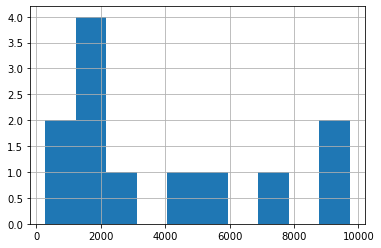

In [54]:
# with prefered we can use histograms to verify the distribution of values
#Check value count of categorical variables other than yes or no

#job
df2['job'].value_counts().hist()

In [62]:
#Check value count of categorical variables other than yes or no

#job
df2['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [28]:
#marital
df2['marital'].value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

In [27]:
#education
df2['education'].value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [81]:
#contact
df2['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [13]:
#contact
df2['contact'].value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [14]:
#poutcome
df2['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [15]:
#Get dummy variables from catgeorical variables
job = pd.get_dummies(df2['job'],prefix='job',drop_first=True)
marital = pd.get_dummies(df2['marital'],prefix='marital',drop_first=True)
education = pd.get_dummies(df2['education'],prefix='education',drop_first=True)
default = pd.get_dummies(df2['default'],prefix='default',drop_first=True)
housing = pd.get_dummies(df2['housing'],prefix='housing',drop_first=True)
loan = pd.get_dummies(df2['loan'],prefix='loan',drop_first=True)
contact = pd.get_dummies(df2['contact'],prefix='contact',drop_first=True)
poutcome = pd.get_dummies(df2['poutcome'],prefix='poutcome',drop_first=True)
y = pd.get_dummies(df2['y'],prefix='y',drop_first=True)

In [16]:
#Add job dummies to dataframe and drop original job column
df2 = df2.join(job)
df2.drop('job', axis=1, inplace=True)
df2.head()

,age,marital,education,default,balance,housing,loan,contact,campaign,pdays,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,married,tertiary,no,2143,yes,no,unknown,1,-1,...,0,0,1,0,0,0,0,0,0,0
1,44,single,secondary,no,29,yes,no,unknown,1,-1,...,0,0,0,0,0,0,0,1,0,0
2,33,married,secondary,no,2,yes,yes,unknown,1,-1,...,1,0,0,0,0,0,0,0,0,0
3,47,married,unknown,no,1506,yes,no,unknown,1,-1,...,0,0,0,0,0,0,0,0,0,0
4,33,single,unknown,no,1,no,no,unknown,1,-1,...,0,0,0,0,0,0,0,0,0,1


In [17]:
#Add marital dummies to dataframe and drop original column
df2 = df2.join(marital)
df2.drop('marital', axis=1, inplace=True)
df2.head()

,age,education,default,balance,housing,loan,contact,campaign,pdays,previous,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single
0,58,tertiary,no,2143,yes,no,unknown,1,-1,0,...,1,0,0,0,0,0,0,0,1,0
1,44,secondary,no,29,yes,no,unknown,1,-1,0,...,0,0,0,0,0,1,0,0,0,1
2,33,secondary,no,2,yes,yes,unknown,1,-1,0,...,0,0,0,0,0,0,0,0,1,0
3,47,unknown,no,1506,yes,no,unknown,1,-1,0,...,0,0,0,0,0,0,0,0,1,0
4,33,unknown,no,1,no,no,unknown,1,-1,0,...,0,0,0,0,0,0,0,1,0,1


In [18]:
#Add education dummies to dataframe and drop original column
df2 = df2.join(education)
df2.drop('education', axis=1, inplace=True)
df2.head()

,age,default,balance,housing,loan,contact,campaign,pdays,previous,poutcome,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,58,no,2143,yes,no,unknown,1,-1,0,unknown,...,0,0,0,0,0,1,0,0,1,0
1,44,no,29,yes,no,unknown,1,-1,0,unknown,...,0,0,1,0,0,0,1,1,0,0
2,33,no,2,yes,yes,unknown,1,-1,0,unknown,...,0,0,0,0,0,1,0,1,0,0
3,47,no,1506,yes,no,unknown,1,-1,0,unknown,...,0,0,0,0,0,1,0,0,0,1
4,33,no,1,no,no,unknown,1,-1,0,unknown,...,0,0,0,0,1,0,1,0,0,1


In [19]:
#Add default dummies to dataframe and drop original column
df2 = df2.join(default)
df2.drop('default', axis=1, inplace=True)
df2.head()

,age,balance,housing,loan,contact,campaign,pdays,previous,poutcome,y,...,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes
0,58,2143,yes,no,unknown,1,-1,0,unknown,no,...,0,0,0,0,1,0,0,1,0,0
1,44,29,yes,no,unknown,1,-1,0,unknown,no,...,0,1,0,0,0,1,1,0,0,0
2,33,2,yes,yes,unknown,1,-1,0,unknown,no,...,0,0,0,0,1,0,1,0,0,0
3,47,1506,yes,no,unknown,1,-1,0,unknown,no,...,0,0,0,0,1,0,0,0,1,0
4,33,1,no,no,unknown,1,-1,0,unknown,no,...,0,0,0,1,0,1,0,0,1,0


In [20]:
#Add housing dummies to dataframe and drop original column
df2 = df2.join(housing)
df2.drop('housing', axis=1, inplace=True)
df2.head()

,age,balance,loan,contact,campaign,pdays,previous,poutcome,y,last_contact,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes
0,58,2143,no,unknown,1,-1,0,unknown,no,197,...,0,0,0,1,0,0,1,0,0,1
1,44,29,no,unknown,1,-1,0,unknown,no,197,...,1,0,0,0,1,1,0,0,0,1
2,33,2,yes,unknown,1,-1,0,unknown,no,197,...,0,0,0,1,0,1,0,0,0,1
3,47,1506,no,unknown,1,-1,0,unknown,no,197,...,0,0,0,1,0,0,0,1,0,1
4,33,1,no,unknown,1,-1,0,unknown,no,197,...,0,0,1,0,1,0,0,1,0,0


In [21]:
#Add loan dummies to dataframe and drop original column
df2 = df2.join(loan)
df2.drop('loan', axis=1, inplace=True)
df2.head()

,age,balance,contact,campaign,pdays,previous,poutcome,y,last_contact,job_blue-collar,...,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes
0,58,2143,unknown,1,-1,0,unknown,no,197,0,...,0,0,1,0,0,1,0,0,1,0
1,44,29,unknown,1,-1,0,unknown,no,197,0,...,0,0,0,1,1,0,0,0,1,0
2,33,2,unknown,1,-1,0,unknown,no,197,0,...,0,0,1,0,1,0,0,0,1,1
3,47,1506,unknown,1,-1,0,unknown,no,197,1,...,0,0,1,0,0,0,1,0,1,0
4,33,1,unknown,1,-1,0,unknown,no,197,0,...,0,1,0,1,0,0,1,0,0,0


In [22]:
#Add contact dummies to dataframe and drop original column
df2 = df2.join(contact)
df2.drop('contact', axis=1, inplace=True)
df2.head()

,age,balance,campaign,pdays,previous,poutcome,y,last_contact,job_blue-collar,job_entrepreneur,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown
0,58,2143,1,-1,0,unknown,no,197,0,0,...,1,0,0,1,0,0,1,0,0,1
1,44,29,1,-1,0,unknown,no,197,0,0,...,0,1,1,0,0,0,1,0,0,1
2,33,2,1,-1,0,unknown,no,197,0,1,...,1,0,1,0,0,0,1,1,0,1
3,47,1506,1,-1,0,unknown,no,197,1,0,...,1,0,0,0,1,0,1,0,0,1
4,33,1,1,-1,0,unknown,no,197,0,0,...,0,1,0,0,1,0,0,0,0,1


In [23]:
#Add poutcome dummies to dataframe and drop original column
df2 = df2.join(poutcome)
df2.drop('poutcome', axis=1, inplace=True)
df2.head()

,age,balance,campaign,pdays,previous,y,last_contact,job_blue-collar,job_entrepreneur,job_housemaid,...,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,1,-1,0,no,197,0,0,0,...,1,0,0,1,0,0,1,0,0,1
1,44,29,1,-1,0,no,197,0,0,0,...,0,0,0,1,0,0,1,0,0,1
2,33,2,1,-1,0,no,197,0,1,0,...,0,0,0,1,1,0,1,0,0,1
3,47,1506,1,-1,0,no,197,1,0,0,...,0,1,0,1,0,0,1,0,0,1
4,33,1,1,-1,0,no,197,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [24]:
#Add y dummies to dataframe and drop original column
df2 = df2.join(y)
df2.drop('y', axis=1, inplace=True)
df2.head()

,age,balance,campaign,pdays,previous,last_contact,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,58,2143,1,-1,0,197,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
1,44,29,1,-1,0,197,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,33,2,1,-1,0,197,0,1,0,0,...,0,0,1,1,0,1,0,0,1,0
3,47,1506,1,-1,0,197,1,0,0,0,...,1,0,1,0,0,1,0,0,1,0
4,33,1,1,-1,0,197,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0


# 4 Feature Selection and Scaling

Perform feature selection from the dataset. Use the following feature selection methods and choose
the feature selection method that has the lowest number of features. If there is a tie, you should select
the first method that has the lowest number of features.

In [25]:
#Define the X (features) and Y (outcome variable)
X = df2.drop(['y_yes'], axis=1)
y = df2['y_yes']
X.shape

(45211, 30)

There are currently 30 features and we need to find out how many of those are statistically significant to keep for our analysis.

### 4.1 Logistic Regression

In [28]:
#obtain the variables with higher coefficients
logisticRegression_method = SelectFromModel(estimator=LogisticRegression(max_iter=5000)).fit(X,y)
logisticRegression_method.estimator_.coef_

array([[-2.38650429e-03,  2.04319432e-05, -9.81546298e-02,
        -1.94198439e-03,  7.41464953e-04,  4.54967840e-04,
        -2.82800518e-01, -1.59217389e-01, -1.87542433e-01,
        -6.02709618e-02,  4.44314562e-01, -9.14389187e-02,
        -1.63408795e-01,  2.27055688e-01, -1.64395012e-01,
         3.72104775e-02, -2.85816878e-02, -2.93303356e-01,
         8.30720887e-02,  1.47659549e-02,  1.14479883e-01,
         5.81009259e-03, -9.09973699e-02, -5.64022699e-01,
        -5.92429370e-01, -9.09150976e-02, -1.09523175e+00,
        -1.25844371e-01,  1.78006420e+00, -8.68562029e-01]])

In [29]:
#Obtain threshold value as the parameter to know which features should be removed
#according to this method
logisticRegression_method.threshold_

0.25564782277620524

In [37]:
#Run get_support() to see which are TRUE for significant features
logisticRegression_method.get_support(indices=True)

array([ 6, 10, 17, 23, 24, 26, 28, 29], dtype=int64)

In [38]:
#Apply transform() to get the subset of features to be used
X_logisticR = logisticRegression_method.transform(X)
X_logisticR.shape

(45211, 8)

Out of 30 features, the logistic regression features selecting method finds 8 features to be statistically significant for the analysis.
'job_blue-collar'
'job_retired'
'marital_married'
'housing_yes'
'loan_yes'
'contact_unknown'
'poutcome_success'
'poutcome_unknown'

In [51]:
#create a dataframe to save selected features by this method

X_logisticR_df = X.iloc[:,[6, 10, 17, 23, 24, 26, 28, 29]].copy()
X_logisticR_df.head()

,job_blue-collar,job_retired,marital_married,housing_yes,loan_yes,contact_unknown,poutcome_success,poutcome_unknown
0,0,0,1,1,0,1,0,1
1,0,0,0,1,0,1,0,1
2,0,0,1,1,1,1,0,1
3,1,0,1,1,0,1,0,1
4,0,0,0,0,0,1,0,1


### 4.2 Linear SVM

In [35]:
#The generalized  linear model is usually used dor feature explanation and observation
svm_method = sm.GLM(y, X, family=sm.families.Binomial())
report=svm_method.fit(fit_intercept=True)
print(report.summary2())

                 Results: Generalized linear model
Model:               GLM               AIC:             28239.9376  
Link Function:       logit             BIC:             -456119.5252
Dependent Variable:  y_yes             Log-Likelihood:  -14090.     
Date:                2021-03-01 15:07  LL-Null:         -16315.     
No. Observations:    45211             Deviance:        28180.      
Df Model:            29                Pearson chi2:    4.92e+04    
Df Residuals:        45181             Scale:           1.0000      
Method:              IRLS                                           
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
age                 -0.0107   0.0015  -7.1383 0.0000 -0.0136 -0.0078
balance              0.0000   0.0000   4.8736 0.0000  0.0000  0.0000
campaign            -0.1144   0.0086 -13.2509 0.0000

In [36]:
#use regularization hyperparameter value 0.001
report.params >= 0.001
X_svm = X.loc[:,abs(report.params) >= 0.001]
X_svm.head()

,age,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,58,1,-1,0,0,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,1
1,44,1,-1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
2,33,1,-1,0,0,1,0,0,0,0,...,0,0,0,1,1,0,1,0,0,1
3,47,1,-1,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
4,33,1,-1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1


The SVM method only eliminated two columns > 'balance' and 'last contact'.

# 5 Classifier Modelling

In [124]:
# const Vars
K_FOLDS = 3 # number of k folds
R_SEED = 42 # Random seed

In [116]:
# Dummy DF just while part 4 is not finished
dummy_df = pd.read_csv('bank-sampled-9K.csv')

In [117]:
df = dummy_df.copy() # change to the outputted df from Section 4

verifying the balance of indep var

<AxesSubplot:>

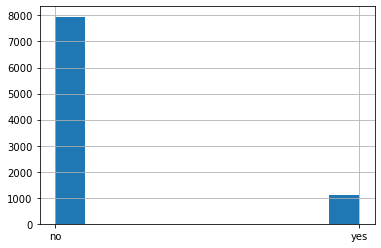

In [102]:
df['y'].hist()

As it is not correctly balanced, let's splitt in a stratified way to be sure the same percentage of **no** and **yes** samples will be splitted to train and test

#### Splitting dataset into 75% train and 25% test

In [121]:
train_df, test_df = train_test_split(df, test_size=0.25, stratify=df['y'], random_state=R_SEED)

In [128]:
skf = StratifiedKFold(n_splits=K_FOLDS)
print(skf)
# StratifiedKFold(n_splits=2, random_state=None, shuffle=False)

StratifiedKFold(n_splits=3, random_state=None, shuffle=False)


# 6 Classifier Model - The Second Try

# 7 Model Evaluation

# 8 Prediction
